# Offline Plotting Tutorial

The new dataset comes with a tool for offline (i.e. not live as the data are coming in) plotting. This notebook explains how to use it and what it is capable of plotting.

The tool in question is the function `plot_by_id`.

In [1]:
%matplotlib notebook
import numpy as np

import qcodes as qc

from typing import List, Dict, Tuple, Any
import matplotlib.pyplot as plt
import qcodes as qc
from qcodes import ParamSpec, new_data_set, new_experiment
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.database import initialise_database

First we make an experimental run, so that we have something to plot.

In [2]:
# if you just deleted your database file, you'll need to init a new one
initialise_database()

In [3]:
new_experiment('test_plot_by_id', 'nosample')

test_plot_by_id#nosample#1@./exp_container_tutorial.db
------------------------------------------------------

In [4]:
# Make a handful of parameters to be used in the examples

x = ParamSpec('x', 'numeric', label='Voltage', unit='V')
t = ParamSpec('t', 'numeric', label='Time', unit='s')
y = ParamSpec('y', 'numeric', label='Voltage', unit='V', depends_on=[x])
y2 = ParamSpec('y2', 'numeric', label='Current', unit='A', depends_on=[x])
z = ParamSpec('z', 'numeric', label='Majorana number', unit='Anyon', depends_on=[x, t])

## A single, simple 1D sweep

In [5]:
data_set = new_data_set('1D-sweep')

data_set.add_parameter(x)
data_set.add_parameter(y)

In [6]:
%%time
xvals = np.linspace(-3.4, 4.2, 250)

for xnum in xvals:
    noise = np.random.randn()*0.1  # multiplicative noise yeah yeah
    data_set.add_result({'x': xnum, 'y': 2*(xnum+noise)**3 - 5*(xnum+noise)**2})

data_set.mark_complete()

Wall time: 5.37 s


Now let us plot that run. The function `plot_by_id` takes the `run_id` of the run to plot as a positional argument. Furthermore, the user may specify the matplotlib axis object (or list of axis objects) to plot on.

If no axes are specified, the function creates new axis object(s). The function returns a tuple of a list of the axes and a list of the colorbar axes (just `None`s if there are no colorbars).

<IPython.core.display.Javascript object>


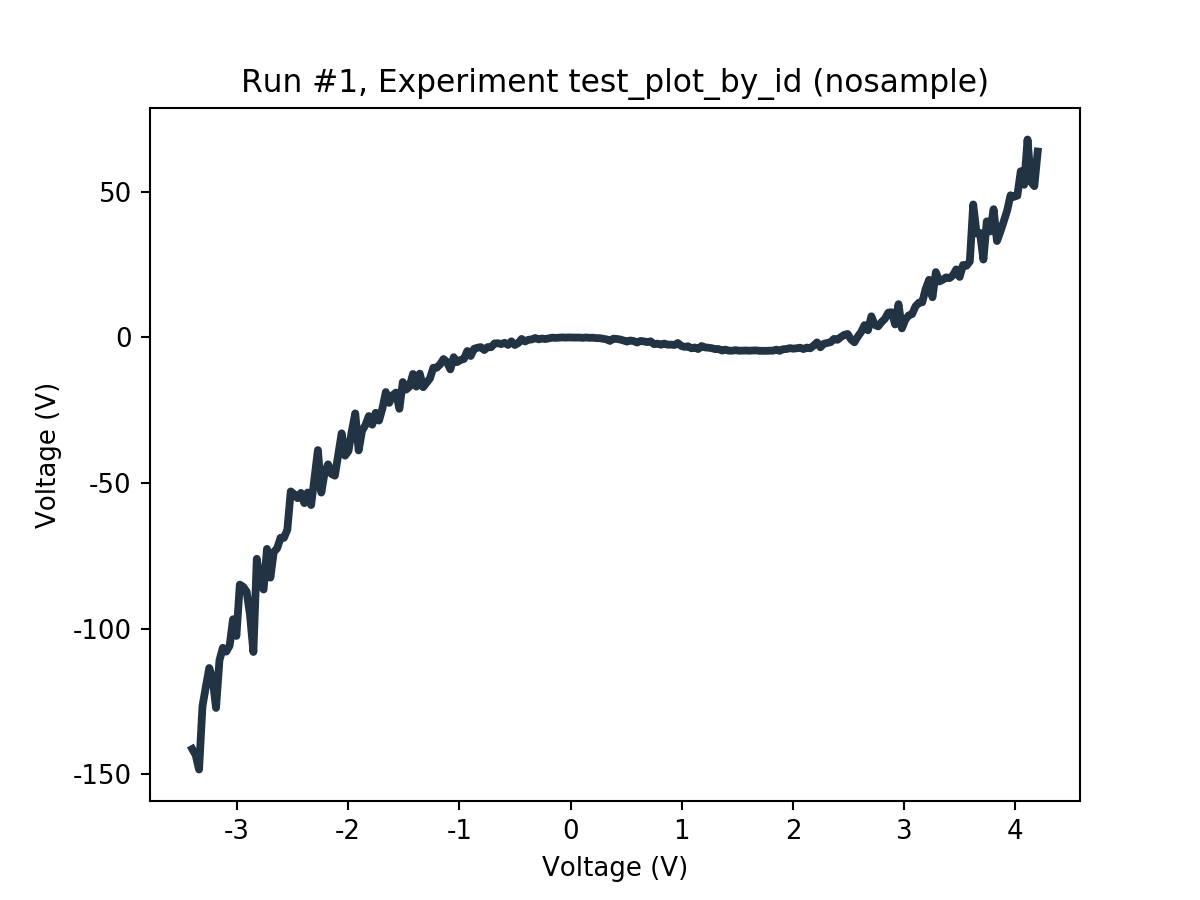

In [7]:
axes, cbaxes = plot_by_id(data_set.run_id)

Using the returned axis, we can e.g. change the plot linewidth and color. We refer to the matplotlib documentation for details on matplotlib plot customization.

In [8]:
my_ax = axes[0]
line = my_ax.lines[0]
line.set_color('#223344')
line.set_linewidth(3)

### Rescaling units and ticks

`plot_by_id` can conveniently rescale the units and ticks of the plot. For example, if one of the axes is voltage in units of `V` but the values are in the range of millivolts, then `plot_by_id` will rescale the ticks of the axis to show `5` instead of `0.005`, and the unit in the axis label will be adjusted from `V` to `mV`.

This feature works with the relevant SI units, and some others. In case the units of the parameter are not from that list, or are simply not specified, ticks and labels are left intact.

The feature can be explicitly turned off by passing `rescale_axes=False` to `plot_by_id`.

The following plot demontrates the feature.

In [9]:
t_1 = ParamSpec('t_1', 'numeric', label='Time', unit='s')
v_1 = ParamSpec('v_1', 'numeric', label='Gate voltage', unit='V', depends_on=[t_1])

data_set_tv = new_data_set('1D-sweep')

data_set_tv.add_parameter(t_1)
data_set_tv.add_parameter(v_1)

for xnum in np.linspace(-3.4, 4.2, 50):
    noise = np.random.randn()*0.1
    data_set_tv.add_result({'t_1': xnum*1e-6, 'v_1': (2*(xnum+noise)**3 - 5*(xnum+noise)**2)*1e3})

data_set_tv.mark_complete()

<IPython.core.display.Javascript object>


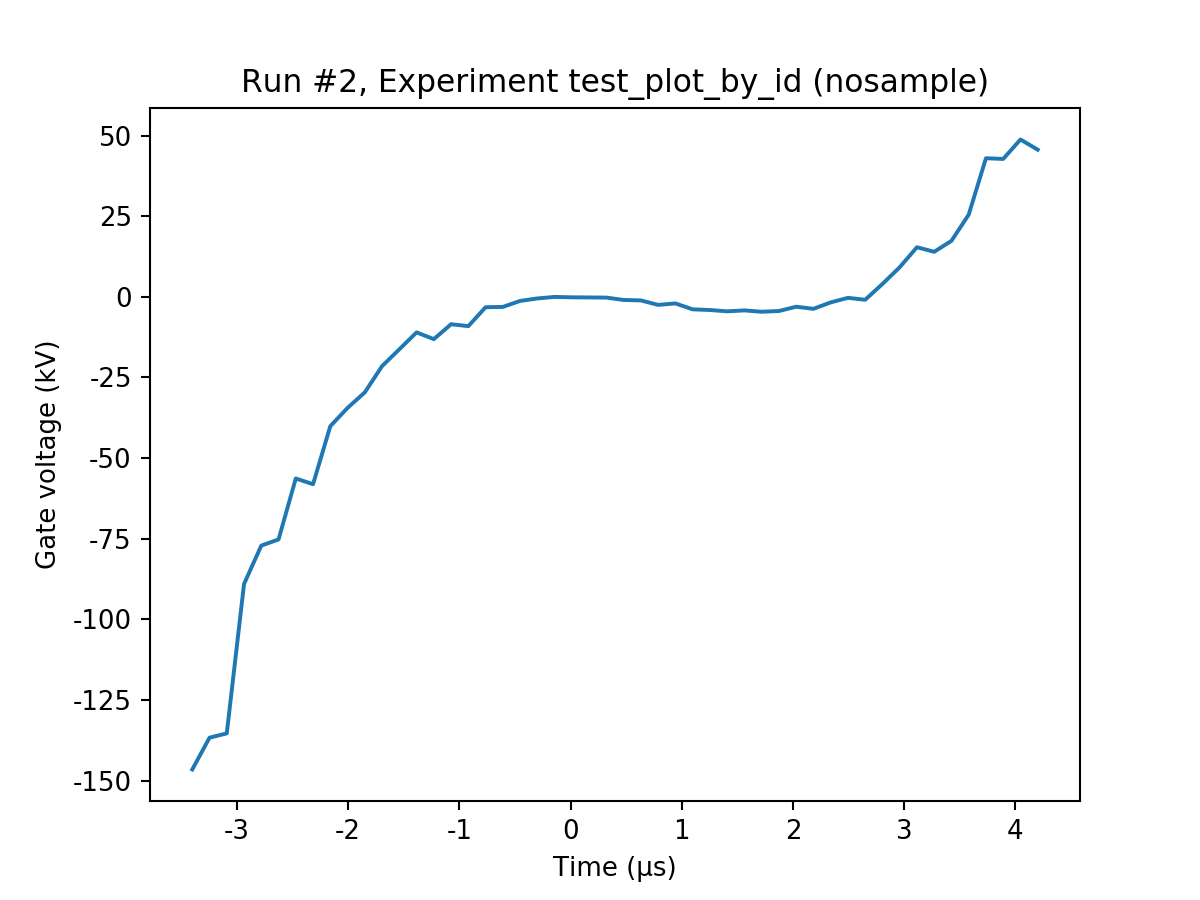

([<matplotlib.axes._subplots.AxesSubplot at 0x210a30b79e8>], [None])

In [10]:
plot_by_id(data_set_tv.run_id)

## Two interleaved 1D sweeps

Now we make a run where two parameters are measured as a function of the same parameter.

In [11]:
data_set = new_data_set('interleaved-1Ds')

In [12]:
data_set.add_parameter(x)
data_set.add_parameter(y)
data_set.add_parameter(y2)

In [13]:
xvals = np.linspace(-5, 5, 250)

for xnum in xvals:
    data_set.add_result({'x': xnum, 'y': xnum**2})
    data_set.add_result({'x': xnum, 'y2': -xnum**2})
data_set.mark_complete()

In such a situation, `plot_by_id` by default creates a new axis for **each** dependent parameter. Sometimes this is not desirable; we'd rather have both plots on the same axis. In such a case, we might pass the same axis twice to `plot_by_id`.

<IPython.core.display.Javascript object>


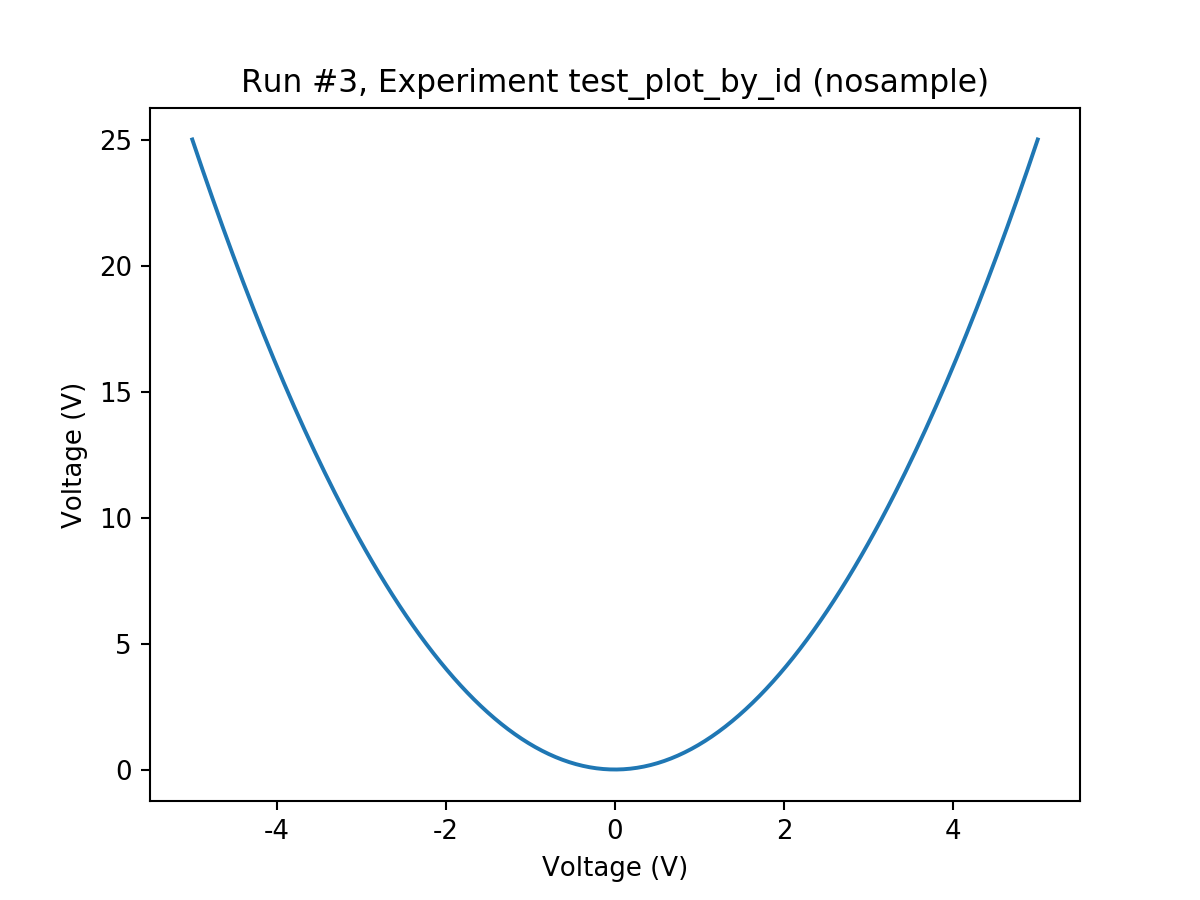

<IPython.core.display.Javascript object>


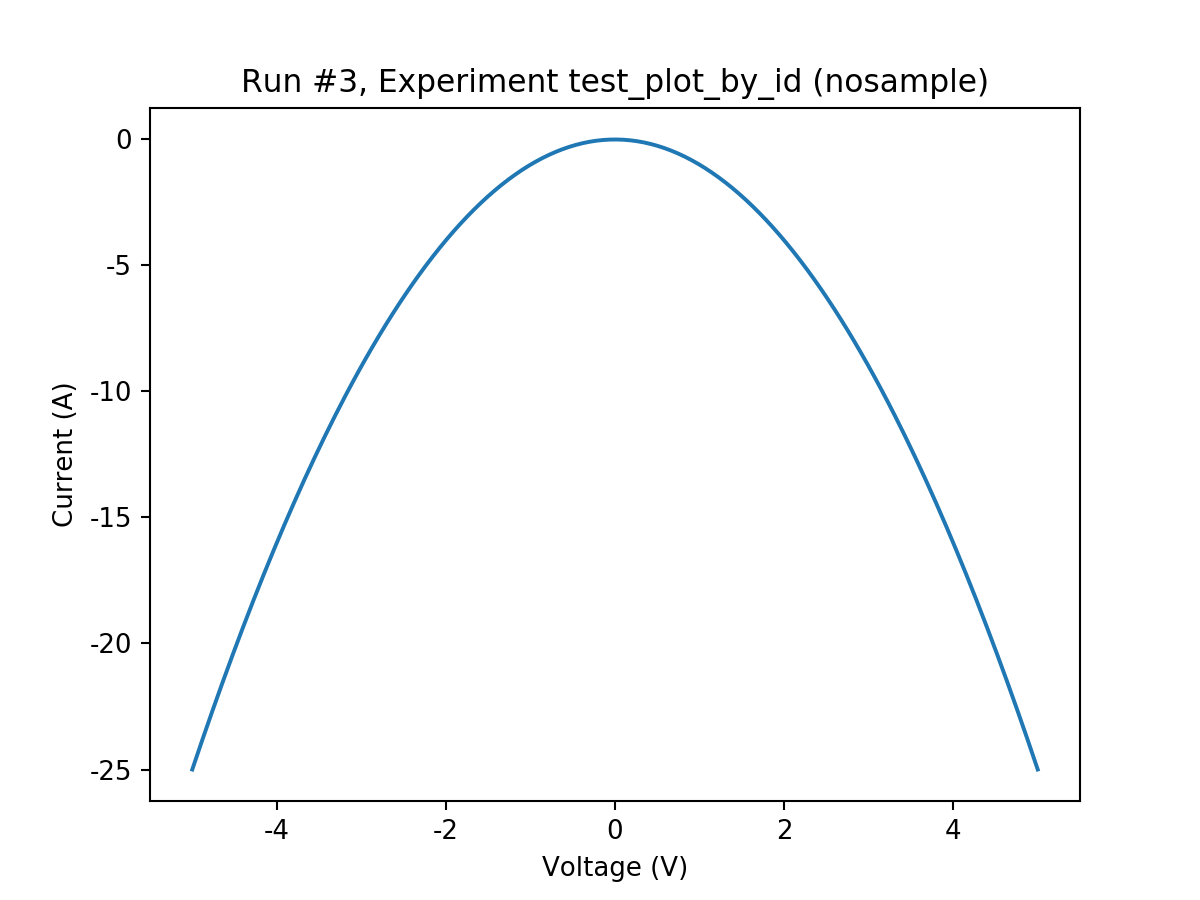

In [14]:
axes, cbaxes = plot_by_id(data_set.run_id)

Let's do that now

<IPython.core.display.Javascript object>


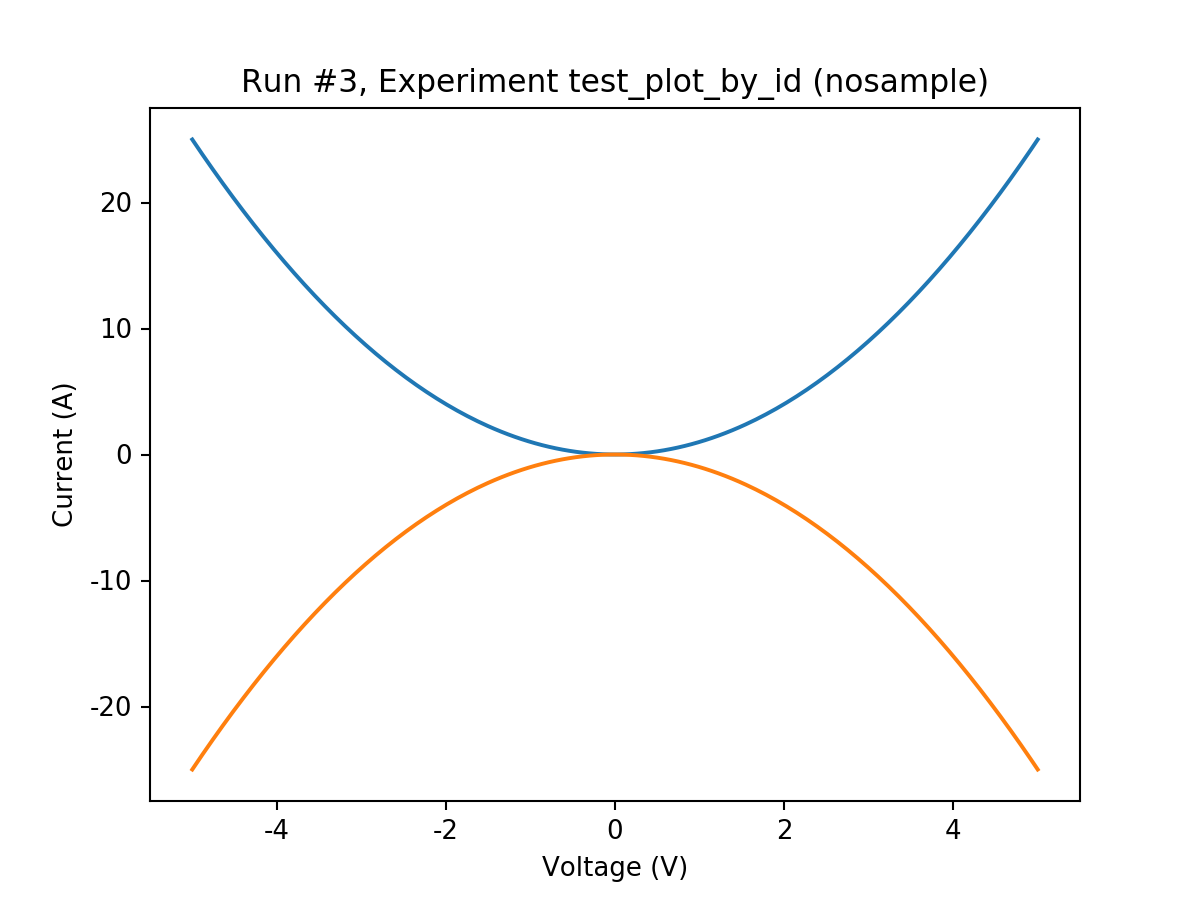

In [15]:
fig, ax = plt.subplots(1)
axes, cbaxes = plot_by_id(data_set.run_id, axes=[ax, ax])

## Regular 2D rectangular sweep scan

For 2D plots, a colorbar is usually present. As mentioned above, `plot_by_id` returns this.

In [16]:
data_set = new_data_set('regular-2D-scan')
data_set.add_parameter(x)
data_set.add_parameter(t)
data_set.add_parameter(z)

In [17]:
xvals = np.linspace(-4, 5, 50)
tvals = np.linspace(-500, 1500, 25)

for xv in xvals:
    for tv in tvals:
        # just some arbitrary semi good looking function
        zv = np.sin(2*np.pi*xv)*np.cos(2*np.pi*0.001*tv) + 0.001*tv
        data_set.add_result({'x': xv, 't': tv, 'z': zv})

data_set.mark_complete()

<IPython.core.display.Javascript object>


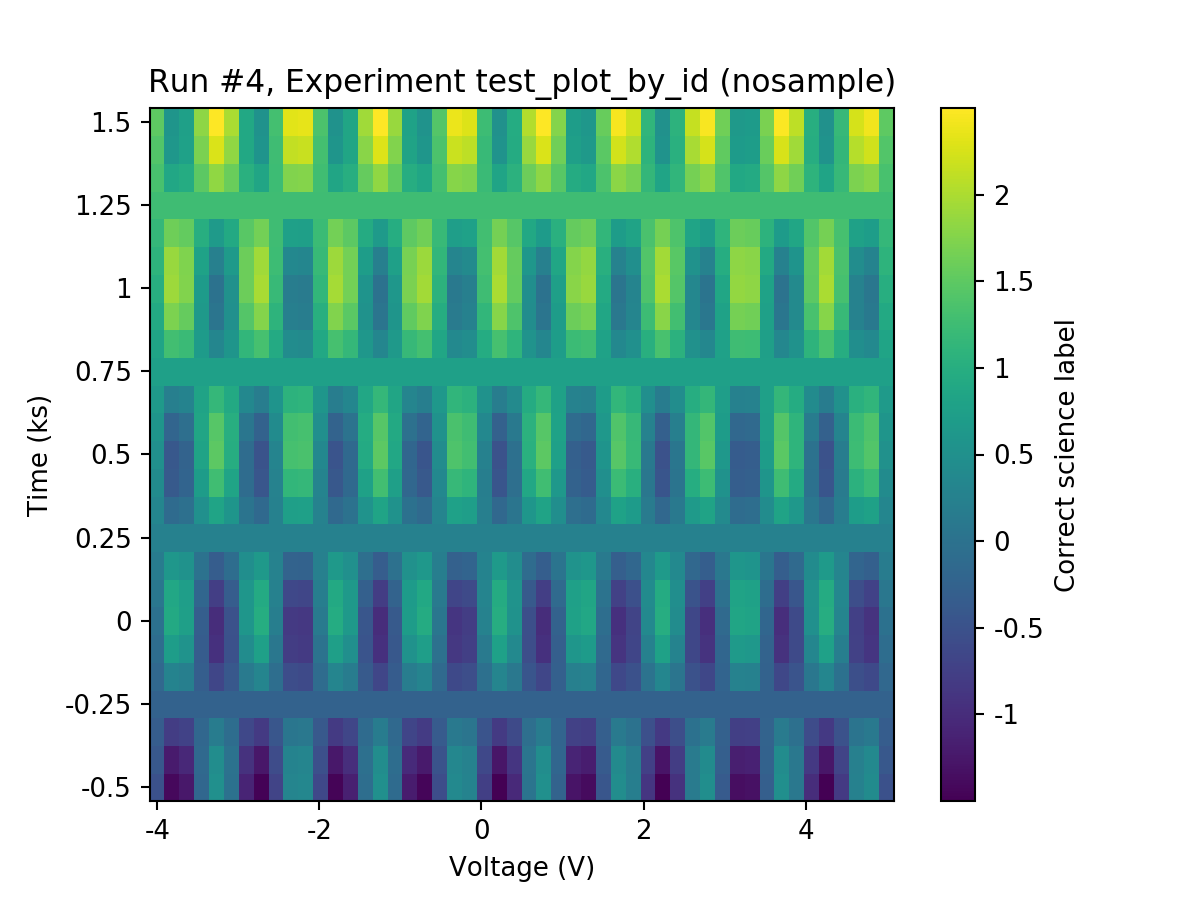

In [18]:
axes, colorbars = plot_by_id(data_set.run_id)

A somewhat normal situation is that the colorbar was somehow mislabelled. Using the returned colorbar, the label can be overwritten.

In [19]:
colorbar = colorbars[0]
colorbar.set_label('Correct science label')

## Warped 2D rectangular sweep scan

A nice feature of the new dataset is that the grid may be warped; it makes no difference.
Here we warp the x axis of the previous scan to increase the resolution in the right half plane.

In [20]:
data_set = new_data_set('warped-2D-scan')
data_set.add_parameter(x)
data_set.add_parameter(t)
data_set.add_parameter(z)

In [21]:
xvals = np.linspace(-4, 5, 50) + np.cos(2/9*np.pi*xvals+np.pi/4)
tvals = np.linspace(-500, 1500, 25)

for xv in xvals:
    for tv in tvals:
        # just some arbitrary semi good looking function
        zv = np.sin(2*np.pi*xv)*np.cos(2*np.pi*0.001*tv) + 0.001*tv
        data_set.add_result({'x': xv, 't': tv, 'z': zv})

data_set.mark_complete()

<IPython.core.display.Javascript object>


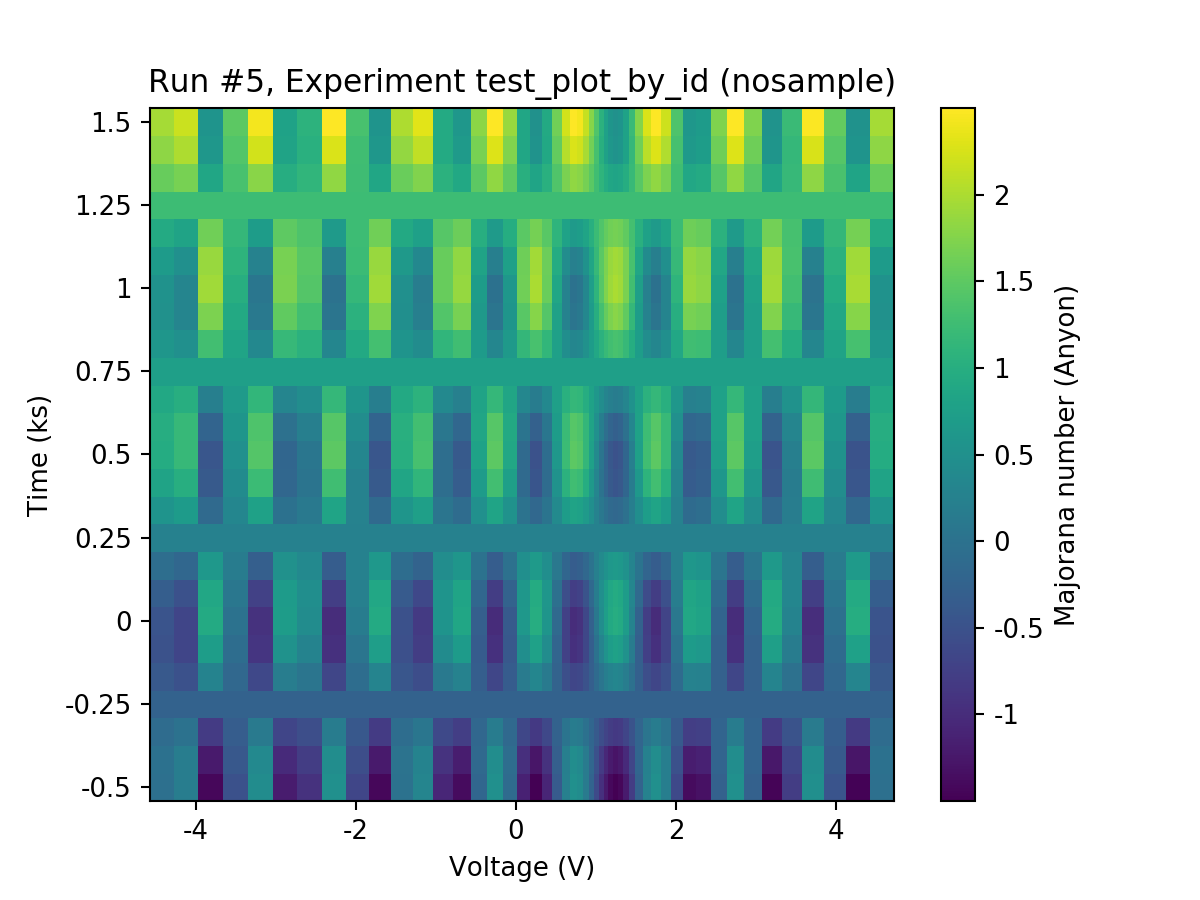

In [22]:
axes, cbaxes = plot_by_id(data_set.run_id)

## Interrupted 2D scans (a hole in the cheese)

In case a sweep in interrupted, the entire grid will not be filled out. This is also supported,
in fact, any single rectangular hole is allowed

In [23]:
data_set = new_data_set('warped-with-hole-2D-scan')
data_set.add_parameter(x)
data_set.add_parameter(t)
data_set.add_parameter(z)

In [24]:
xvals = np.linspace(-4, 5, 50) + np.cos(2/9*np.pi*xvals+np.pi/4)
tvals = np.linspace(-500, 1500, 25)

# define two small forbidden range functions
def no_x(xv):
    if xv > 0 and xv < 3:
        return True
    else:
        return False
    
def no_t(tv):
    if tv > 0 and tv < 450:
        return True
    else:
        return False

for xv in xvals:
    for tv in tvals:
        if no_x(xv) and no_t(tv):
            continue
        else:
            # just some arbitrary semi good looking function
            zv = np.sin(2*np.pi*xv)*np.cos(2*np.pi*0.001*tv) + 0.001*tv
            data_set.add_result({'x': xv, 't': tv, 'z': zv})

data_set.mark_complete()

<IPython.core.display.Javascript object>


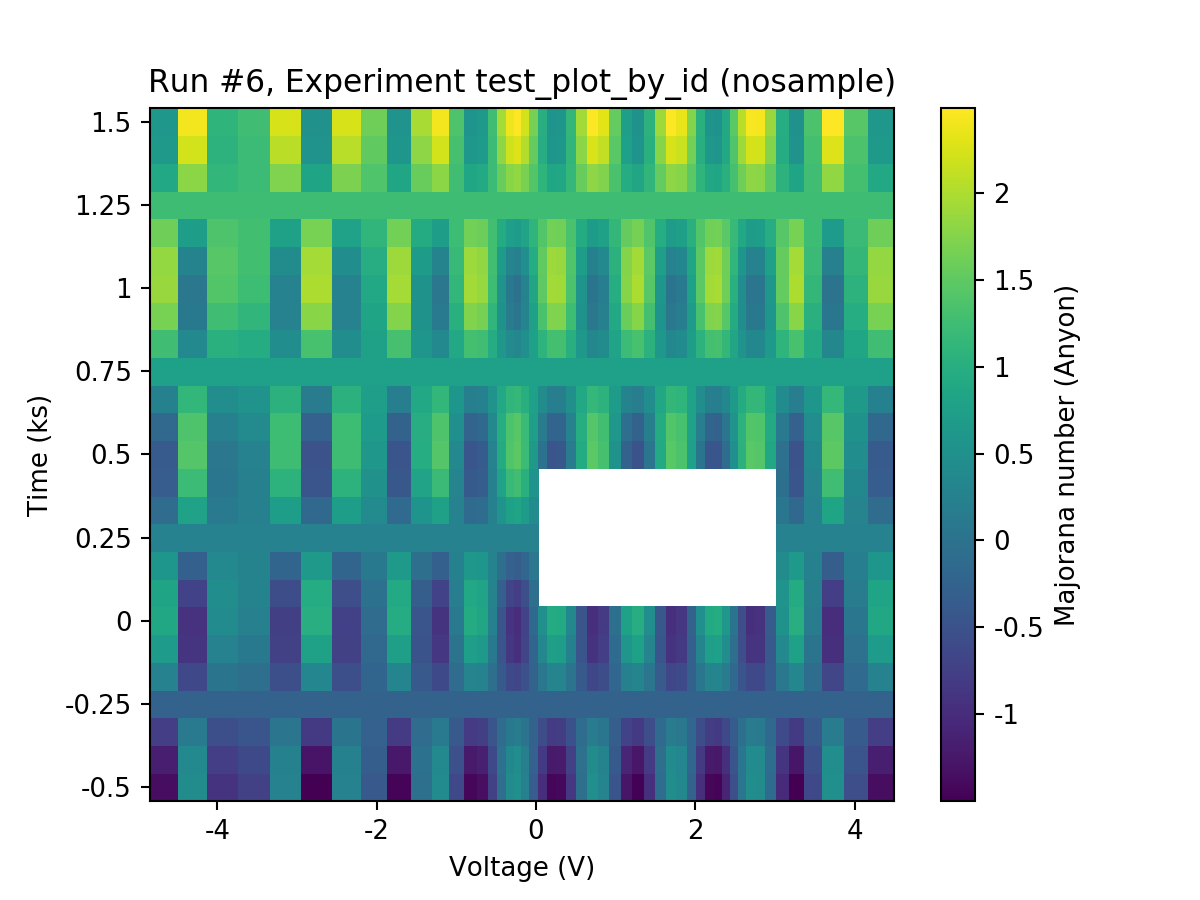

In [25]:
axes, colorbars = plot_by_id(data_set.run_id)

## Plots with string (categorial) data

`plot_by_id` support plotting categorial data (strings) as well. The tick labels of the plots contain the string values.

Note that this feature requires `matplotlib` version `2.1`.

### 2D cases

#### String-valued indepentent parameter

Let's use an example of a qubit measurement. These measurements are quite complicated, but for the sake of this example we will abstract away from all the complexity, and simulate the values of the relevant parameters.

In this example, the string-valued parmater is independent.

In [26]:
def gen_random_unit_vectors(dims: int, number: int) -> np.ndarray:
    """
    Generate an array of a given numer of random unit vectors of given
    dimensions.
    """
    vecs = np.random.normal(size=(number, dims))
    mags = np.linalg.norm(vecs, axis=-1)
    return vecs / mags[..., np.newaxis]

In [27]:
# 2-qubit correlator
two_q_corr_values = ['X_X', 'X_Y', 'X_Z', 'X_I', 'Y_Y', 'Y_Z', 'Y_I', 'Z_Z', 'Z_I']
#                      note the >>> paramtype <<< it is important
#                                   \/ \/ \/
two_q_corr = ParamSpec('two_q_corr', 'text', label='2-qubit correlator', unit='')

# The values of the qubit state correspond to 2-qubit correlators
val = ParamSpec('val', 'numeric', label='Component value', unit='', depends_on=[two_q_corr])

data_set = new_data_set('sweep-with-strings')

data_set.add_parameter(two_q_corr)
data_set.add_parameter(val)

values = gen_random_unit_vectors(len(two_q_corr_values), 1)[0]
for two_q_corr_id, value in zip(two_q_corr_values, values):
    data_set.add_result({'two_q_corr': two_q_corr_id, 'val': value})

data_set.mark_complete()

run_id_strings = data_set.run_id

<IPython.core.display.Javascript object>


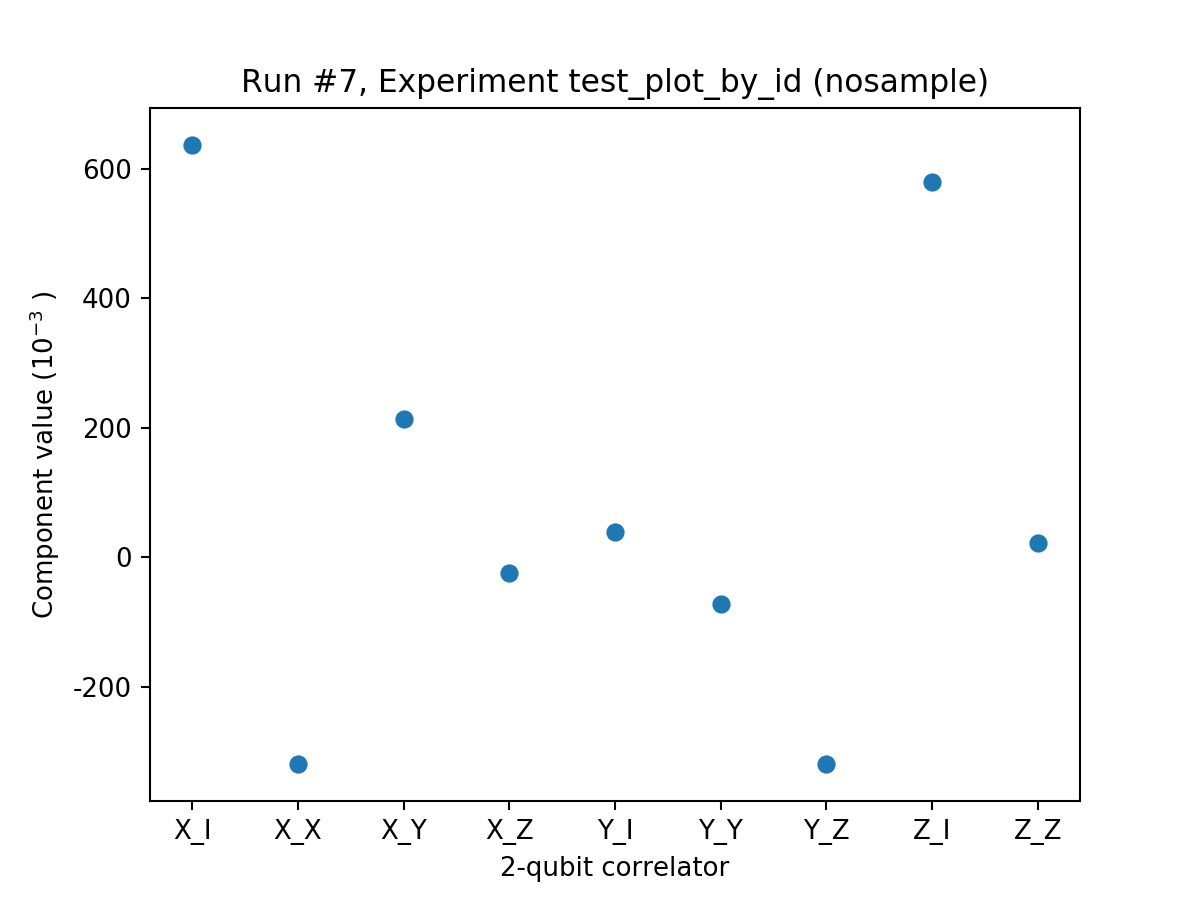

([<matplotlib.axes._subplots.AxesSubplot at 0x210a45dfcc0>], [None])

In [28]:
plot_by_id(run_id_strings)

#### String-valued dependent value

In this example, let's plot the case where string-valued parameter is the dependent one.

In [29]:
numeric_param = ParamSpec('numeric_param', 'numeric', label='Numeric value', unit='J')

string_values = ['X_X', 'X_Y', 'X_Z', 'X_I', 'Y_Y', 'Y_Z', 'Y_I', 'Z_Z', 'Z_I']
string_param = ParamSpec('string_param', 'text', label='String parameter', unit='', depends_on=[numeric_param])

data_set = new_data_set('sweep-with-strings')

data_set.add_parameter(numeric_param)
data_set.add_parameter(string_param)

numeric_values = gen_random_unit_vectors(len(string_values), 1)[0]
for string_value, numeric_value in zip(string_values, numeric_values):
    data_set.add_result({'string_param': string_value, 'numeric_param': numeric_value})

data_set.mark_complete()

run_id_strings_dependent = data_set.run_id

<IPython.core.display.Javascript object>


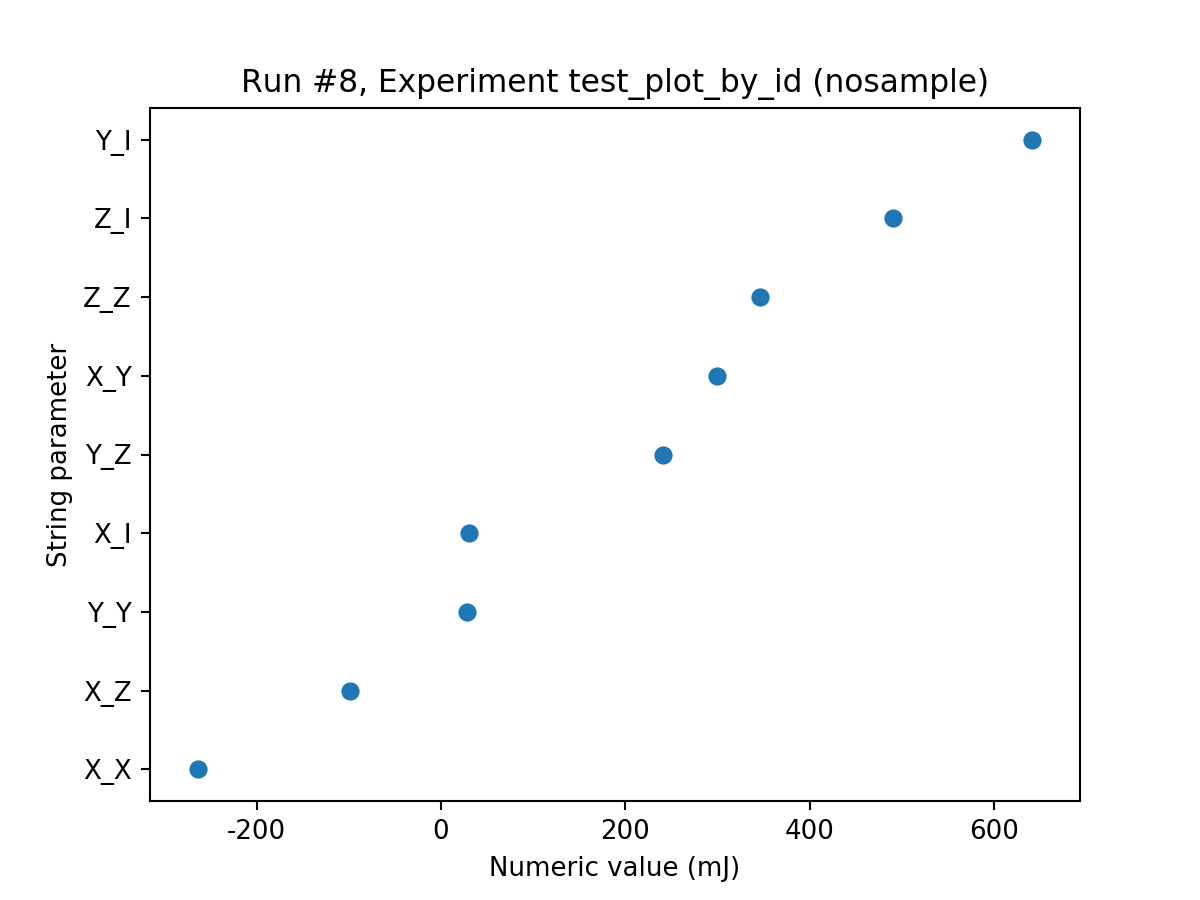

([<matplotlib.axes._subplots.AxesSubplot at 0x210a45f5240>], [None])

In [30]:
plot_by_id(run_id_strings_dependent)

### 3D case

At the moment, __3D plotting__ of data that has __string-valued__ components is __not fully supported.__ Moreover, choosing an apropriate plot type for such cases will be revisited.

#### String-valued independent parameter

In [35]:
# 2-qubit correlator
two_q_corr_values = ['X_X', 'X_Y', 'X_Z', 'X_I', 'Y_Y', 'Y_Z', 'Y_I', 'Z_Z', 'Z_I']
#                      note the >>> paramtype <<< it is important
#                                   \/ \/ \/
two_q_corr = ParamSpec('two_q_corr', 'text', label='2-qubit correlator', unit='')

# Let's use the number of the measurement as a 2nd dimension
meas_number = ParamSpec('meas_number', 'numeric', label='Measurement number', unit='#')

# The values of the qubit state correspond to 2-qubit correlators
val = ParamSpec('val', 'numeric', label='Component value', unit='', 
                depends_on=[two_q_corr, meas_number])

data_set = new_data_set('sweep-with-strings')

data_set.add_parameter(two_q_corr)
data_set.add_parameter(meas_number)
data_set.add_parameter(val)

n_measurements = 20
values = gen_random_unit_vectors(len(two_q_corr_values), n_measurements)

for n_meas in range(n_measurements):
    for two_q_corr_id, value in zip(two_q_corr_values, values[n_meas]):
        data_set.add_result({'two_q_corr': two_q_corr_id, 'val': value, 'meas_number': n_meas})

data_set.mark_complete()

run_id_3d_strings = data_set.run_id

<IPython.core.display.Javascript object>


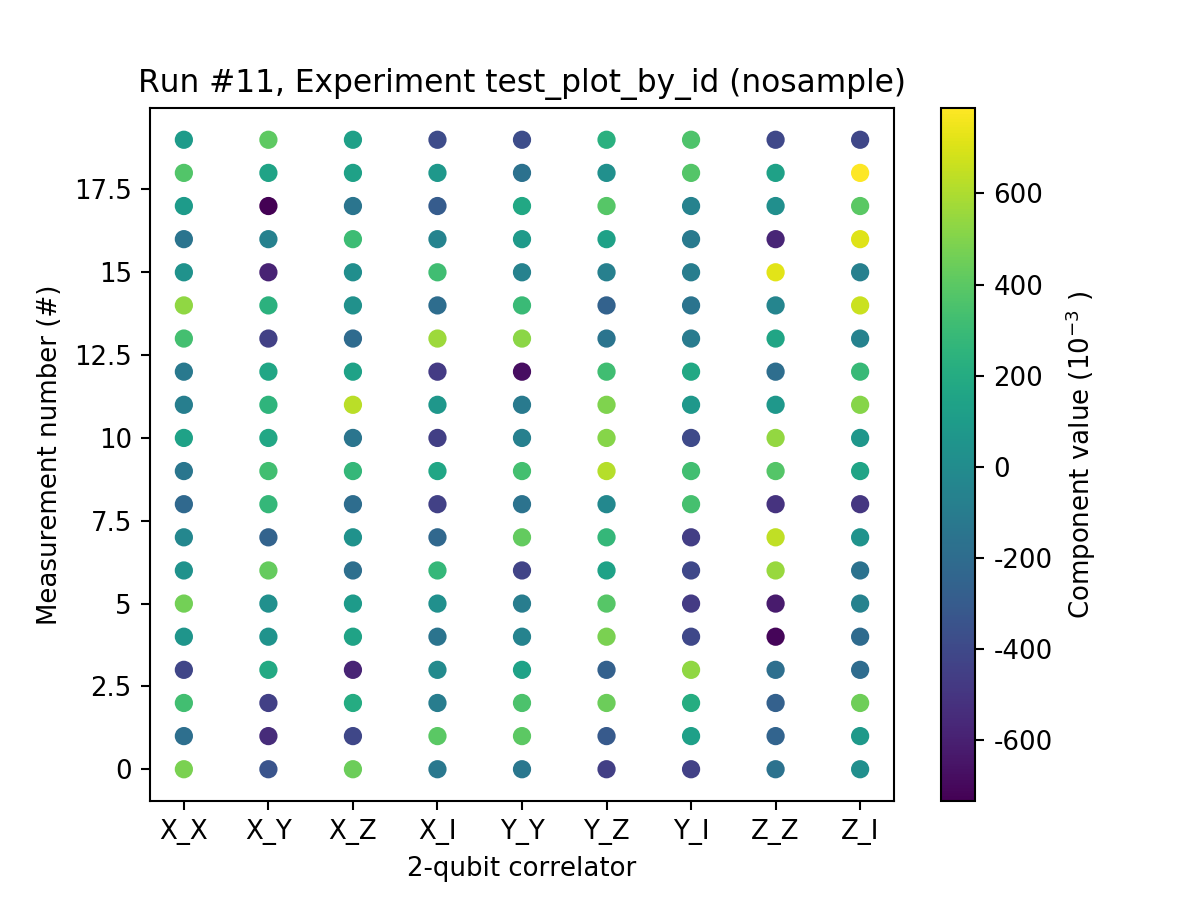

([<matplotlib.axes._subplots.AxesSubplot at 0x210aac4d7f0>],
 [<matplotlib.colorbar.Colorbar at 0x210aac8d4e0>])

In [36]:
plot_by_id(run_id_3d_strings)

#### String-valued dependent parameter

This case may produce __incorrect__ plots, see an example below.

In [37]:
# Let's use the number of the measurement as a 2nd dimension
meas_number = ParamSpec('meas_number', 'numeric', label='Measurement number', unit='#')

# The values of the qubit state correspond to 2-qubit correlators
val = ParamSpec('val', 'numeric', label='Component value', unit='')

# 2-qubit correlator
two_q_corr_values = ['X_X', 'X_Y', 'X_Z', 'X_I', 'Y_Y', 'Y_Z', 'Y_I', 'Z_Z', 'Z_I']
#                      note the >>> paramtype <<< it is important
two_q_corr = ParamSpec('two_q_corr', 'text', label='2-qubit correlator', unit='',
                       depends_on=[val, meas_number])

data_set = new_data_set('sweep-with-strings')

data_set.add_parameter(meas_number)
data_set.add_parameter(val)
data_set.add_parameter(two_q_corr)

n_measurements = 20
values = gen_random_unit_vectors(len(two_q_corr_values), n_measurements)

for n_meas in range(n_measurements):
    for two_q_corr_id, value in zip(two_q_corr_values, values[n_meas]):
        data_set.add_result({'two_q_corr': two_q_corr_id, 'val': value, 'meas_number': n_meas})

data_set.mark_complete()

run_id_3d_strings_dep = data_set.run_id

<IPython.core.display.Javascript object>


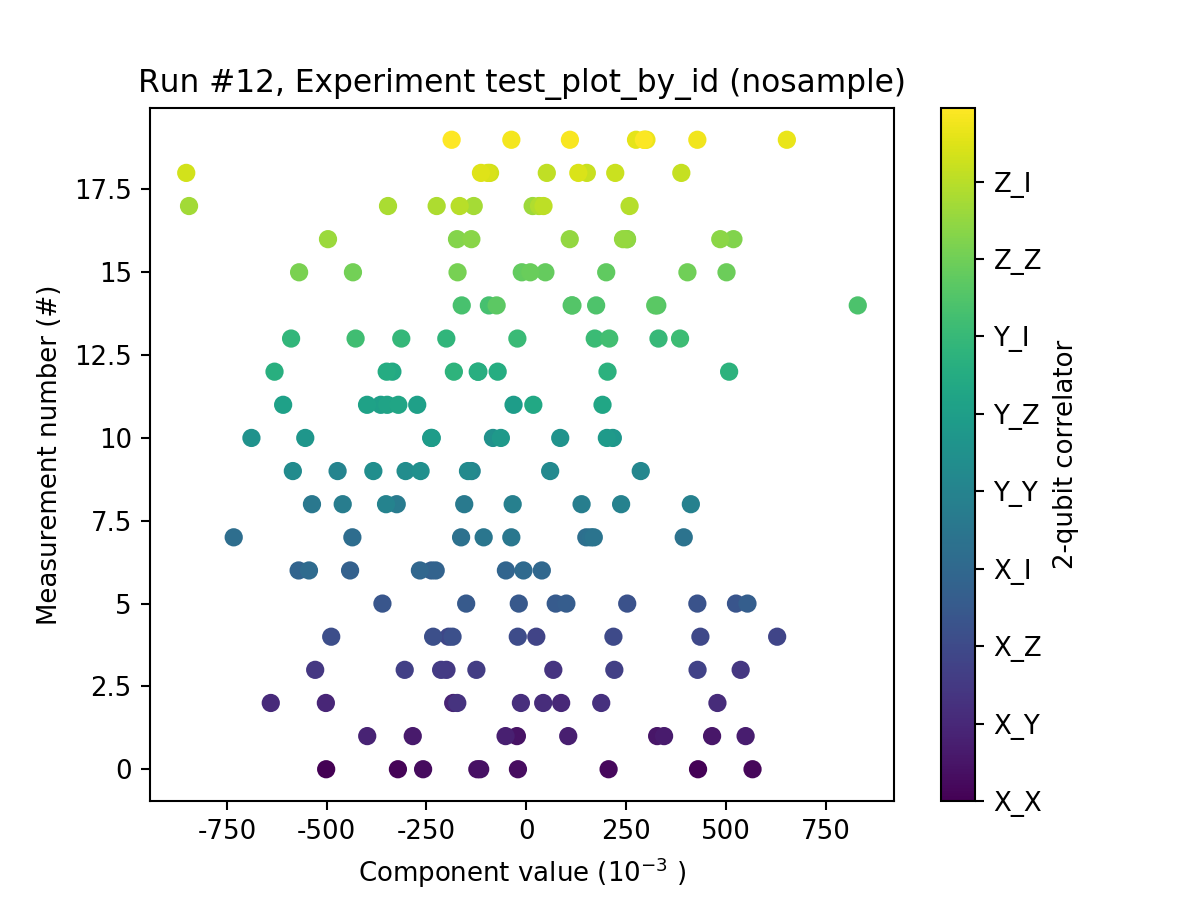

([<matplotlib.axes._subplots.AxesSubplot at 0x210ab56a240>],
 [<matplotlib.colorbar.Colorbar at 0x210a43c46a0>])

In [38]:
plot_by_id(run_id_3d_strings_dep)

## Fancy plotting

As a final example, let us combine several plots in one window.

We first make a little grid of axes.

<IPython.core.display.Javascript object>


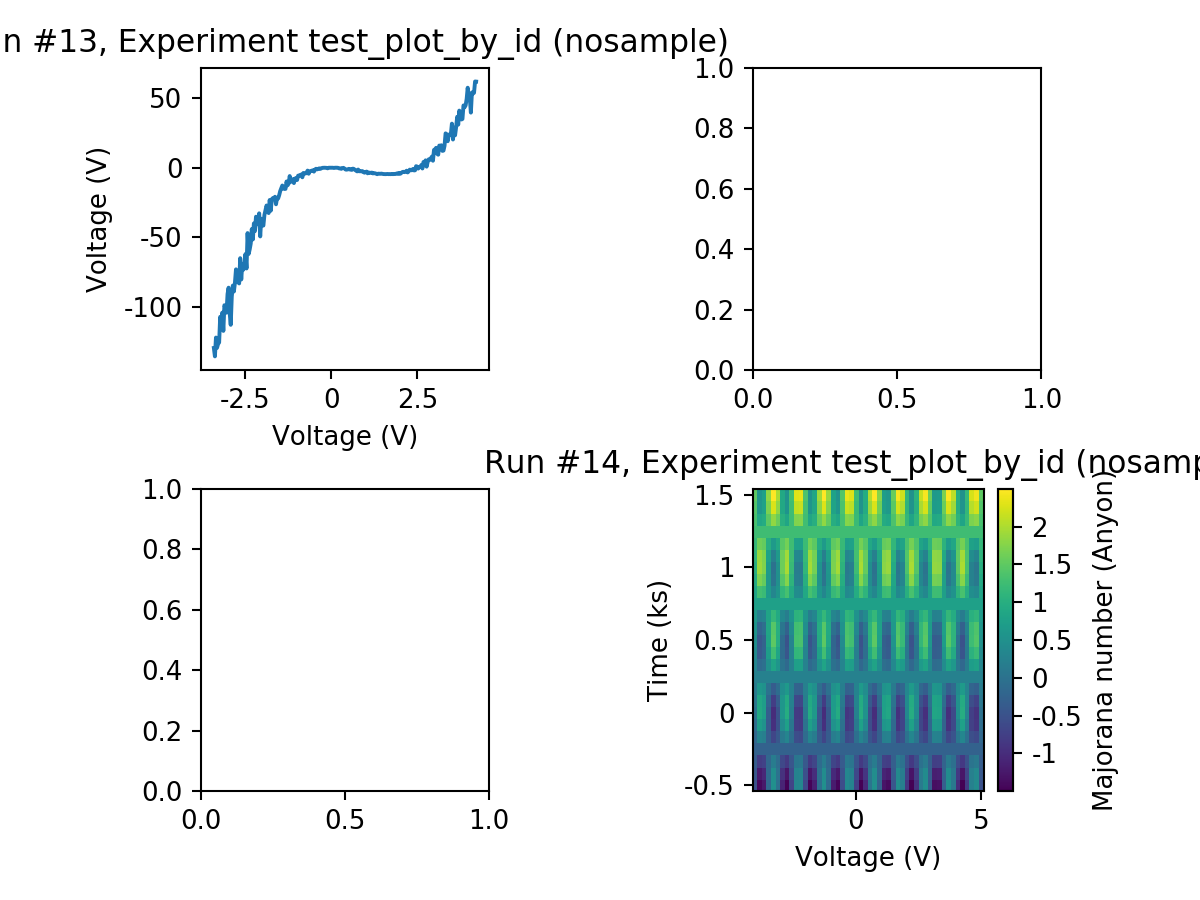

In [39]:
fig, figaxes = plt.subplots(2, 2)

Next, we make some runs (shamelessly copy-pasting from above).

In [40]:
# First run

data_set = new_data_set('1D-sweep')

data_set.add_parameter(x)
data_set.add_parameter(y)

xvals = np.linspace(-3.4, 4.2, 250)

for xnum in xvals:
    noise = np.random.randn()*0.1  # multiplicative noise yeah yeah
    data_set.add_result({'x': xnum, 'y': 2*(xnum+noise)**3 - 5*(xnum+noise)**2})

data_set.mark_complete()
rid1 = data_set.run_id

# Second run

data_set = new_data_set('2D-sweep')
data_set.add_parameter(x)
data_set.add_parameter(t)
data_set.add_parameter(z)

xvals = np.linspace(-4, 5, 50)
tvals = np.linspace(-500, 1500, 25)
for xv in xvals:
    for tv in tvals:
        # just some arbitrary semi good looking function
        zv = np.sin(2*np.pi*xv)*np.cos(2*np.pi*0.001*tv) + 0.001*tv
        data_set.add_result({'x': xv, 't': tv, 'z': zv})

data_set.mark_complete()

rid2 = data_set.run_id

And then we put them just where we please.

In [41]:
axes, colorbars = plot_by_id(rid1, figaxes[0, 0])

In [42]:
axes, colorbars = plot_by_id(rid2, figaxes[1, 1], colorbars)

Note that if we want to replot on an axis with a colorbar we probably also want to reuse the colorbar

In [43]:
axes, colorbars = plot_by_id(rid2, figaxes[1, 1], colorbars)

In [44]:
fig.tight_layout()